# Historical Network Constrained Linear Optimal Power Flow

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a historical 3 day period.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.style.use('ggplot')
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2016-12-01 00:00:00'
end = '2016-12-03 23:30:00'
year = int(start[0:4])
# time step as fraction of hour
time_step = 0.5

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [4]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='historical', merge_generators=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [5]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, loads, storage_units


To approximate n-1 security and allow room for reactive power flows, don't allow any line to be loaded above 70% of their thermal rating

In [6]:
contingency_factor = 0.7
network.lines.s_max_pu[0:99] *= contingency_factor

## Running the optimisation

In [7]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

AC    29
DC     6
Name: carrier, dtype: int64
INFO:pypsa.linopf:Prepare linear problem
AC    29
DC     6
Name: carrier, dtype: int64
INFO:pypsa.linopf:Total preparation time: 1.35s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-u6ptv4h3.lp
Reading time = 0.83 seconds
obj: 426654 rows, 111457 columns, 754520 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 426654 rows, 111457 columns and 754520 nonzeros
Model fingerprint: 0x512bb2b9
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 9e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 419121 rows and 89967 columns
Presolve time: 0.26s
Presolved: 7533 rows, 22634 columns, 47339 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.179e+04
 Factor NZ  : 1.578e+05 (roughly 13 MB of memory)
 Factor Ops : 4.772e+06 (less t

INFO:pypsa.linopf:Optimization successful. Objective value: 7.92e+07


('ok', 'optimal')

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [8]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# interconnector exports
exports = network.loads_t.p
# multiply by negative one to convert it as a generator
# i.e. export is a positive load, but negative generator
exports['Interconnectors Export'] = exports.iloc[:, -6:].sum(axis=1) * -1
interconnector_export = exports[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

carrier,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),Coal,EfW Incineration,Interconnectors Import,Landfill Gas,Hydro,Natural Gas,Nuclear,Oil,Sewage Sludge Digestion,Shoreline Wave,Small Hydro,Solar Photovoltaics,Wind Offshore,Wind Onshore,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,
2016-12-01 00:00:00,244.2,0.0,0.0,0.0,356.436,1159.000046,743.5,77.048420,19054.162816,6510.14,0.0,44.4,23.0,9.320824,0.0,2029.771908,4308.020133,440.000000,1032.1
2016-12-01 00:30:00,244.2,0.0,0.0,0.0,356.436,1291.000043,743.5,66.636473,17860.256182,6510.14,0.0,44.4,23.0,8.061253,0.0,2102.063136,4342.919450,272.387567,1032.1
2016-12-01 01:00:00,244.2,0.0,0.0,0.0,356.436,1297.000034,743.5,66.115873,18353.117770,6510.14,0.0,44.4,23.0,7.998275,0.0,2137.095627,4403.434199,239.562067,1032.1
2016-12-01 01:30:00,244.2,0.0,0.0,0.0,356.436,1297.000037,743.5,65.074678,19025.849662,6510.14,0.0,44.4,23.0,7.872318,0.0,2134.869382,4431.751318,259.906689,1032.1
2016-12-01 02:00:00,244.2,0.0,0.0,0.0,356.436,1298.000036,743.5,56.224523,18829.688687,6510.14,0.0,44.4,23.0,6.801683,0.0,2119.227783,4407.020308,250.361001,1032.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-03 21:30:00,244.2,0.0,0.0,0.0,356.436,1686.000041,743.5,216.685648,26187.083227,6510.14,0.0,44.4,24.0,25.314354,0.0,1908.477044,916.763756,300.000000,1032.1
2016-12-03 22:00:00,244.2,0.0,0.0,0.0,356.436,1416.000017,743.5,108.342822,25168.278098,6510.14,0.0,44.4,24.0,12.657177,0.0,1921.804072,966.242319,300.000000,1032.1
2016-12-03 22:30:00,244.2,0.0,0.0,0.0,356.436,1439.000036,743.5,98.493475,23745.990461,6510.14,0.0,44.4,24.0,11.506524,0.0,1927.268283,1000.065341,300.000000,1032.1


Graph the power output of the different generation types...

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

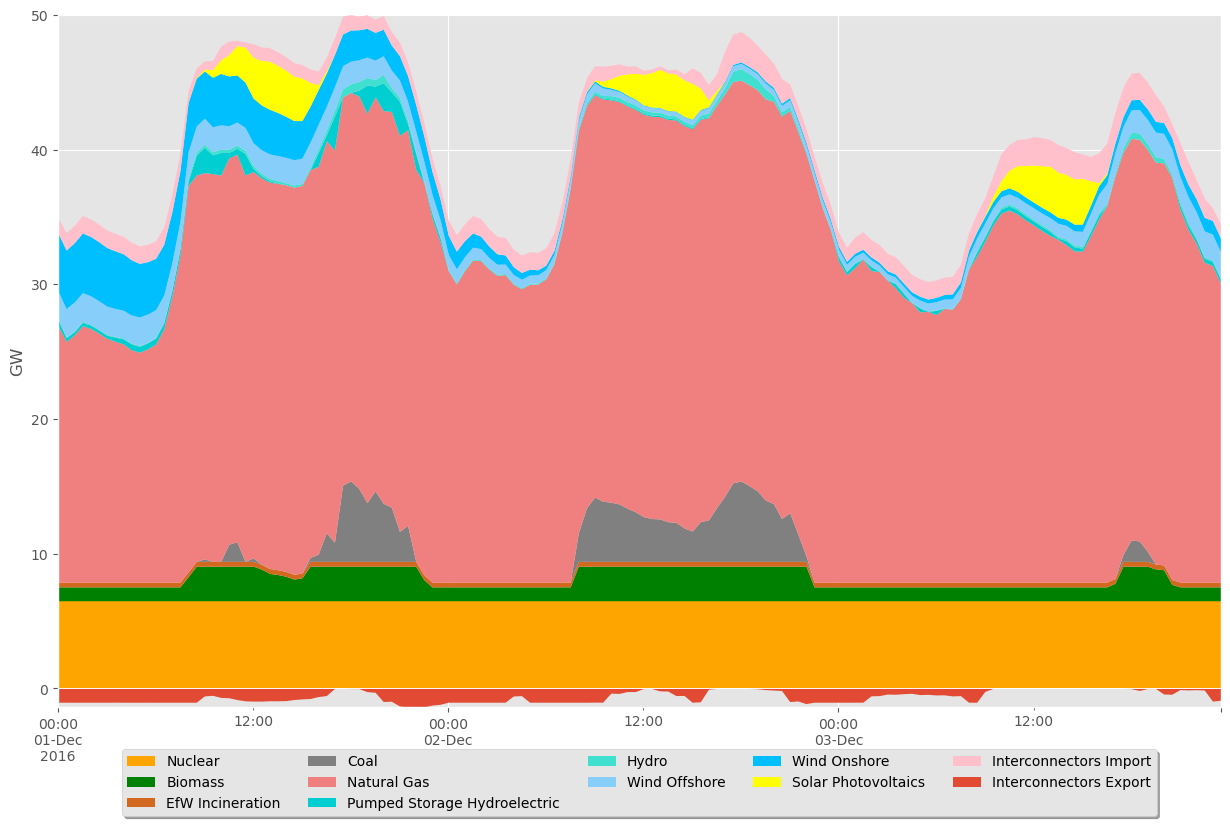

In [9]:
cols = ["Nuclear", 'Shoreline Wave', 'Biomass',
        'EfW Incineration',
        "Coal", "Oil", "Natural Gas",
        "Pumped Storage Hydroelectric", 'Hydro',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting storage

Graph the pumped hydro dispatch and state of charge...

Text(0.5, 0, '')

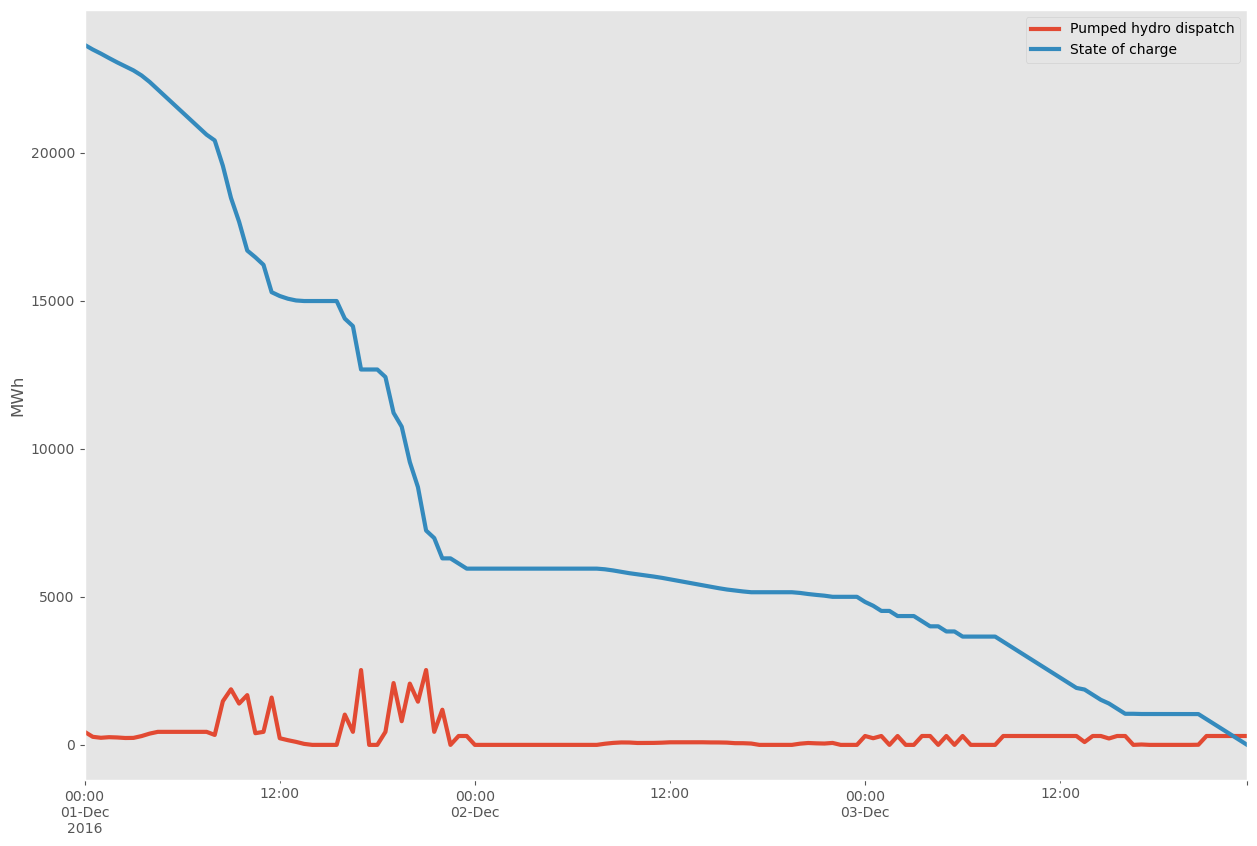

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

## Plotting line loading

Look at the line loading stats and graph...

In [11]:
now = network.snapshots[139]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    105.000000
mean      -0.079940
std        0.182926
min       -0.657591
25%       -0.173556
50%       -0.048893
75%        0.024649
max        0.306329
dtype: float64

(<matplotlib.collections.PatchCollection at 0x20e93a28bb0>,
 <matplotlib.collections.LineCollection at 0x20e814b3a90>)

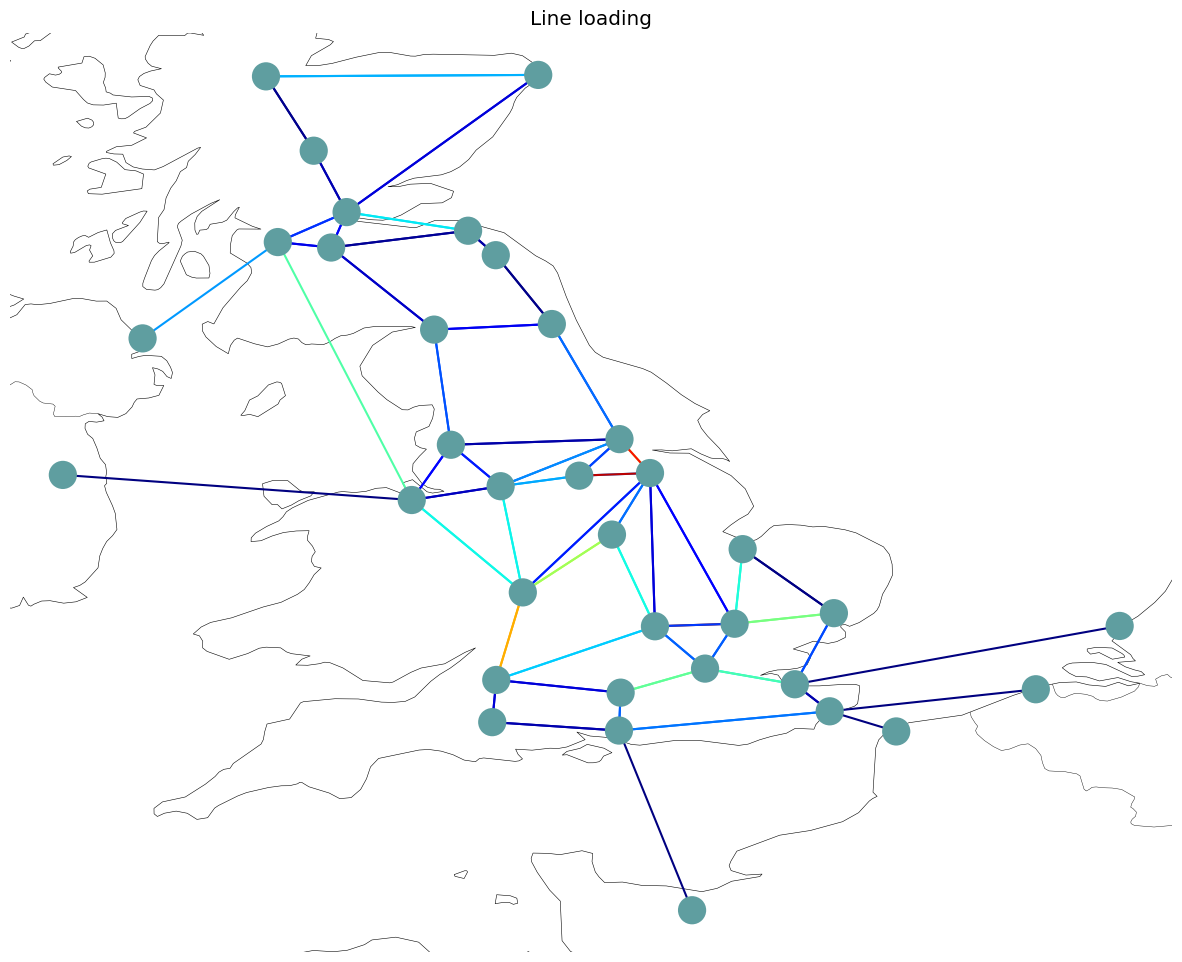

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

## Plotting locational marginal prices

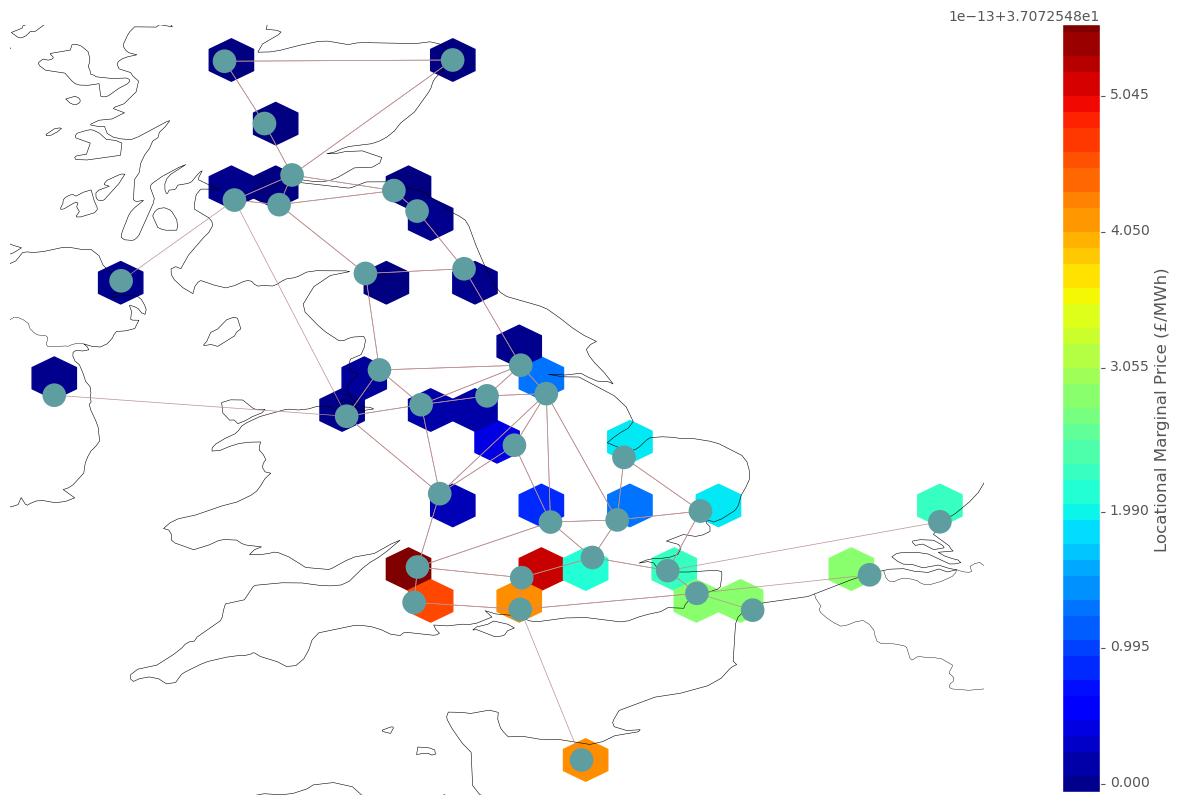

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

In [14]:
network.buses_t.marginal_price

Bus,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Kemsley,Sellindge,Lovedean,S.W.Penisula,Netherlands,Belgium,France1,France2,Ireland,N. Ireland
snapshot,,,,,,,,,,,,,,,,,,,,,
2016-12-01 00:00:00,0.000000,8.735771,55.035751,37.127190,37.127190,37.127190,37.127190,37.127190,37.127190,37.127190,...,37.127190,37.127190,37.127190,37.127190,37.127190,37.127190,37.127190,37.127190,37.127190,37.127190
2016-12-01 00:30:00,0.000000,7.828818,49.321910,33.272626,30.592715,33.116542,34.871647,34.878175,34.703955,36.011535,...,37.127190,37.133477,37.142365,37.145009,37.127190,37.133477,37.133477,37.142365,37.921491,30.592715
2016-12-01 01:00:00,0.000000,7.828818,49.321910,33.272626,30.592715,33.116542,34.871647,34.878175,34.703955,36.011535,...,37.127190,37.133477,37.142365,37.145009,37.127190,37.133477,37.133477,37.142365,37.921491,30.592715
2016-12-01 01:30:00,0.000000,7.828818,49.321910,33.272626,30.590055,33.116387,34.873234,34.879769,34.705376,36.014255,...,37.131017,37.137311,37.146207,37.148853,37.131017,37.137311,37.137311,37.146207,37.926106,30.590055
2016-12-01 02:00:00,0.000000,7.828818,49.321910,33.272626,30.590055,33.116387,34.873234,34.879769,34.705376,36.014255,...,37.131017,37.137311,37.146207,37.148853,37.131017,37.137311,37.137311,37.146207,37.926106,30.590055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-03 21:30:00,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,...,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548
2016-12-03 22:00:00,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,...,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548
2016-12-03 22:30:00,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,...,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548,37.072548


## Plotting curtailment

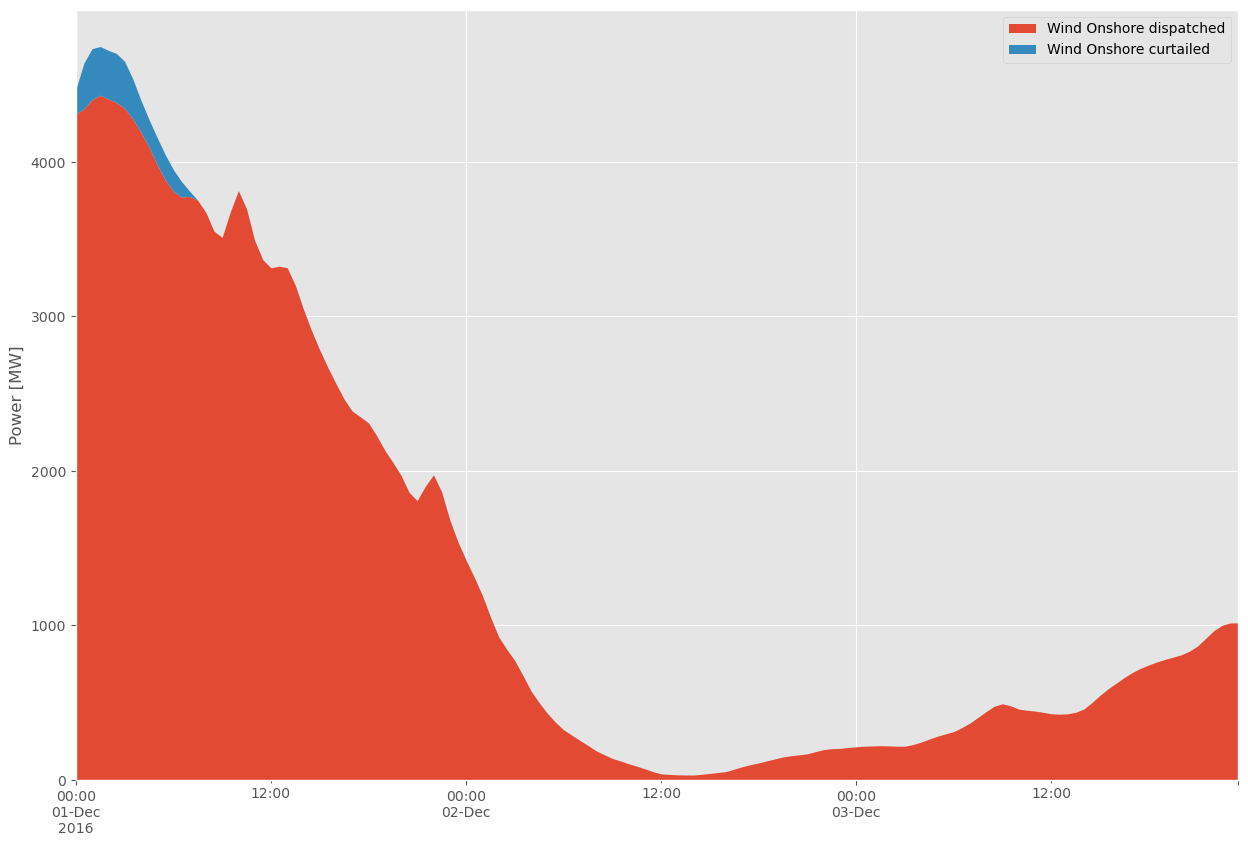

In [15]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()